# Car Racing DQN agent 
Training a DQN agent for the OpenAI gym Car-Racing-v0 environment.


### Notes
- The first 50 frames afer resetting the environment are of the camera zooming into the track, and look very different from "normal" gameplay.
    - I exclude these frames from the training of each episode.
- Preprocessing
    - I have applied similar preprocessing steps as used in the DeepMind paper.
    - Images are converted to grayscale.
    - Consecutive frames are then stacked to form a $96 x 96 x 3$ image, where the channels represent the game screen at different points in time instead of RGB channels.

### Environment setup

        conda create -c conda-forge -n gymenv swig pip  
        conda activate gymenv  
        pip install gym==0.19   # Use 0.17.3 to render in the notebook, however this has memory leak issues because of xvfb
        pip install Box2D gym
        pip install gym[all]

        pip install tensorflow
        pip install matplotlib

        pip install gym pyvirtualdisplay   
        sudo apt-get install -y xvfb python-opengl ffmpeg  

        # The following steps are so that I can access the new env in Azure ML notebooks
        conda install ipykernel
        python -m ipykernel install --user --name gymenv --display-name "Python (gymenv)"




### Useful links

#### Papers
https://arxiv.org/pdf/1312.5602.pdf   
https://arxiv.org/pdf/1509.06461v3.pdf 

#### Environment setup  
https://stackoverflow.com/questions/60268769/gyms-box-2d-openai-doesnt-install-successfully-pip-error  
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-terminal#add-new-kernels  

#### Code examples
https://keras.io/examples/rl/deep_q_network_breakout/  
https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c  
https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/   
https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN  
https://github.com/pekaalto/DQN 

#### DDQN
https://ai.stackexchange.com/questions/22609/how-does-the-target-network-in-double-dqns-find-the-maximum-q-value-for-each-act 

#### Other
https://greentec.github.io/reinforcement-learning-third-en/#fn:4
https://stackoverflow.com/questions/59737875/keras-change-learning-rate  
https://ai.stackexchange.com/questions/12268/in-q-learning-shouldnt-the-learning-rate-change-dynamically-during-the-learnin  
https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time  
https://stackoverflow.com/questions/52770780/why-is-my-deep-q-net-and-double-deep-q-net-unstable  
https://greentec.github.io/reinforcement-learning-third-en/#double-dqn 


#### Import libraries

In [1]:
import gym
import numpy as np
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from collections import deque
import time
import random
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, \
                        GlobalMaxPool2D, BatchNormalization, Dropout, Activation
from keras.backend import clear_session

display = Display(visible=0, size=(1400, 900))
display.start()

from dqn_agent import *
from dqn_agent_trainer import *
from utils import *
from cnn_utils import *

## Train the DQN agent

Lessons
- More actions → Bad/Unnecessary
- Screen cropping → Bad (at least the way I did it) action meters are useful, confirmed by CNN analysis
- Negative action cutoff → Might be bad if too low, not enough experience of how to handle spin outs

Things to try
- Simplified networks
- Less distance between frames?
- Double DQN with smaller network?
- Base DQN with smaller network?
- Clarify frames and steps

In [2]:
actions = np.array([[0.0, 1.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.8],
                    [0.0, 0.0, 0.0]]   
                )

action_probs = np.array([0.5] + [(1 - 0.5)/4.0] * 4)

def modified_cnn_model():
    """Returns a CNN model - same architecture as in the DeepMind paper."""

    model = Sequential()
    model.add(Conv2D(32, 8, activation='relu', strides=4, input_shape=(96, 96, 4)))
    model.add(Conv2D(64, 4, activation='relu', strides=2))
    model.add(Conv2D(64, 3, activation='relu', strides=1))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation="linear"))

    opt = Adam(learning_rate=0.00025, epsilon=1e-7, clipnorm=1.0)
    loss_function = keras.losses.Huber()
    model.compile(loss=loss_function, optimizer=opt, metrics=['mean_squared_error'])

    return model

# Create a DQN agent
dqn_agent = DQNAgent(actions,
                    action_probs,
                    lr=0.00025, 
                    batch_size=32, 
                    gamma=0.95,
                    user_defined_model_function=modified_cnn_model,
                    ddqn=True)

# Create the agent trainer
agent_trainer = DQNAgentTrainer(img_len=96, 
                                frame_stack_num=4, 
                                number_of_episodes=1000, 
                                epsilon=0.1, 
                                epsilon_min=0.05, 
                                epsilon_step_episodes=100.0,
                                final_epsilon_episode=10000,
                                max_replay_memory_size=100000, 
                                min_replay_memory_size=1000, 
                                random_action_frames=5000,
                                max_consecutive_negative_rewards=150, 
                                update_target_model_frames=5000, 
                                max_frames_per_episode=10000,
                                skip_frames=4, 
                                save_training_frequency=10000, 
                                save_models=False, 
                                save_run_results=True,
                                verbose_cnn=50, 
                                verbose=True)


In [ ]:
# Define environment and train agent
env = gym.make("CarRacing-v0")
agent_trainer.train_agent(env, dqn_agent)

Episode: 455
Ending episode: done True, consecutive negative rewards 23
Total frames in episode: 238
Replay buffer size: 89969
Total frame count: 89969
Epsilon: 0.05
Total reward for episode: 791.666666666652
Running average rewards: 440.29327616804716 

Track generation: 1143..1433 -> 290-tiles track
1/1 [==============================] - 0s 21ms/step - loss: 0.0904 - mean_squared_error: 0.4578


### Analysis

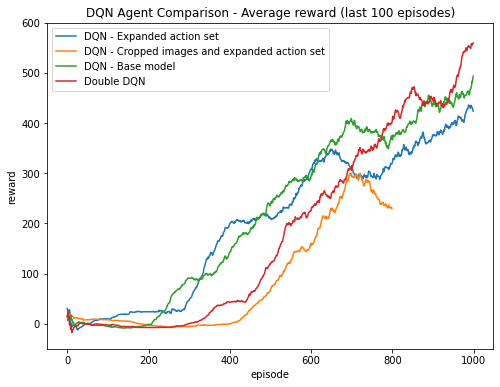

In [7]:
agent_episode_rewards = []
labels = ["DQN - Expanded action set",
            "DQN - Cropped images and expanded action set",
            "DQN - Base model",
            "Double DQN"]
runs = ["./runs/dqn_results_20220411-233445.pickle",
        "./runs/dqn_results_20220409-160900.pickle",
        "./runs/dqn_results_20220411-040945.pickle",
        "./runs/dqn_results_20220412-095012.pickle"]

for run in runs:
    with open(run, 'rb') as fp:
        results = pickle.load(fp)
    agent_episode_rewards.append(results['episode_rewards'])

plot_reward_comparison(agent_episode_rewards, labels, ylim=(-50, 600))

### Render the DQN agent

In [9]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [11]:
# with open("./runs/dqn_results_20220411-040945.pickle", 'rb') as fp:
#     results = pickle.load(fp)
actions = results['actions']
model = results['model']
env = wrap_env(gym.make("CarRacing-v0"))

# Reset environment and process image
s_0 = env.reset()
s_0 = image_processing(s_0, 96)
grayscale_state_buffer = deque([s_0]*13)
s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

episode_rewards = 0

i = 0
while True:
    # Full throttle for first 50 frames
    if i < 50:
        a_0 = 0
    else:
        a_0 = np.argmax(model.predict(s_0_stacked))
    s_1, reward, done, _ = env.step(actions[a_0])
    episode_rewards += reward

    if done:
        break

    # Append latest state and get new stacked representation
    s_1 = image_processing(s_1, 96)
    grayscale_state_buffer.append(s_1)
    s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

    i += 1

# Append rewards
print(episode_rewards)
show_video()
env.close()

Track generation: 1151..1443 -> 292-tiles track
697.2508591065102


In [4]:
with open("./runs/dqn_results_20220411-040945.pickle", 'rb') as fp:
    results = pickle.load(fp)

actions = results['actions']
model = results['model']


def live_trial(episodes, env, render=False):
    """Do a live trial."""

    total_rewards = []

    for episode in range(episodes):
        episode_rewards = 0

        # Reset environment and process image
        s_0 = env.reset()
        s_0 = image_processing(s_0, 96)
        grayscale_state_buffer = deque([s_0]*13)
        s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

        i = 0
        while True:
            if render:
                env.render()
            # Full throttle for first 50 frames
            if i < 50:
                a_0 = 0
            else:
                a_0 = np.argmax(model.predict(s_0_stacked))
            s_1, reward, done, _ = env.step(actions[a_0])
            episode_rewards += reward

            if done:
                break

            # Append latest state and get new stacked representation
            s_1 = image_processing(s_1, 96)
            grayscale_state_buffer.append(s_1)
            s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

            i += 1

        # Append rewards
        print(episode_rewards)
        total_rewards.append(episode_rewards)

    if render:
        show_video()

    env.close()

    return total_rewards


env = gym.make("CarRacing-v0")
total_rewards = live_trial(100, env, render=False)



2022-04-11 05:57:57.739933: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-11 05:57:57.740079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blockade-runner): /proc/driver/nvidia/version does not exist
2022-04-11 05:57:57.740950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Track generation: 1056..1324 -> 268-tiles track
401.87265917601303
Track generation: 1098..1377 -> 279-tiles track
331.65467625897526
Track generation: 1029..1294 -> 265-tiles track
816.6666666666523
Track generation: 1051..1318 -> 267-tiles track
877.443609022535
Track generation: 1009..1270 -> 261-tiles track
50.000000000004064
Track generation: 1076..1349 -> 273-tiles track
833.8235294117438
Track generation: 1157..1450 -> 293-tiles track


KeyboardInterrupt: 

In [39]:
env.close()

### CNN activation model

In [12]:
with open("./runs/dqn_results_20220412-095012.pickle", 'rb') as fp:
    results = pickle.load(fp)

actions = results['actions']
model = results['model']

In [14]:
def live_trial(env):
    """Do a live trial."""

    # Reset environment and process image
    s_0 = env.reset()
    s_0 = image_processing(s_0, 96)
    grayscale_state_buffer = deque([s_0]*13)
    s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

    state_list = []
    i = 0
    while True:
        if i%10 == 0:
            state_list.append(s_0_stacked)
        # Full throttle for first 50 frames
        if i < 50:
            a_0 = 0
        else:
            a_0 = np.argmax(model.predict(s_0_stacked))
        s_1, reward, done, _ = env.step(actions[a_0])

        if done:
            break

        # Append latest state and get new stacked representation
        s_1 = image_processing(s_1, 96)
        grayscale_state_buffer.append(s_1)
        s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

        i += 1

    env.close()

    return state_list

env = gym.make("CarRacing-v0")
state_list = live_trial(env)

# Create activation model
activation_model = create_activation_model(model)

Track generation: 1076..1349 -> 273-tiles track


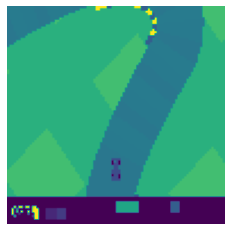

In [23]:
# Plot an image
idx = 22
img = state_list[idx][:, :, :, :]

plt.figure()
plt.imshow(img[0, :, :, 3])
plt.axis('off')
plt.show()

conv2d


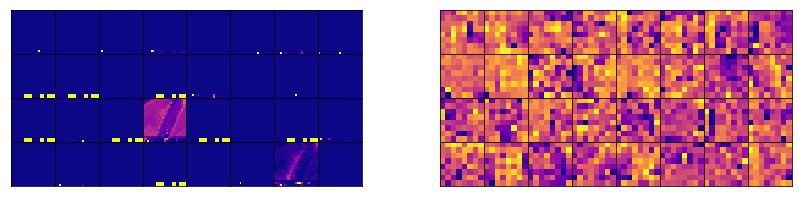

conv2d_1


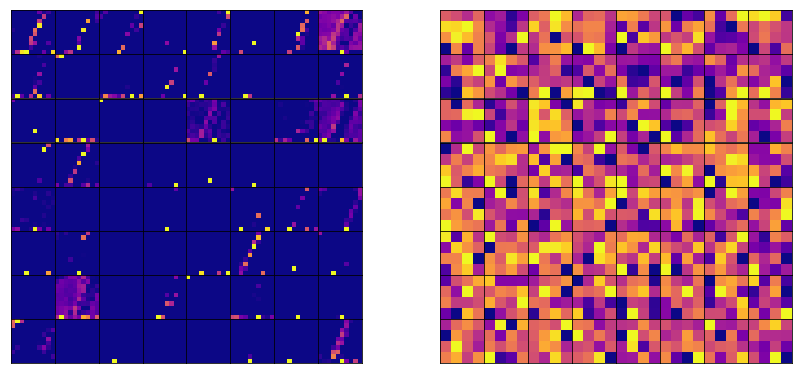

conv2d_2


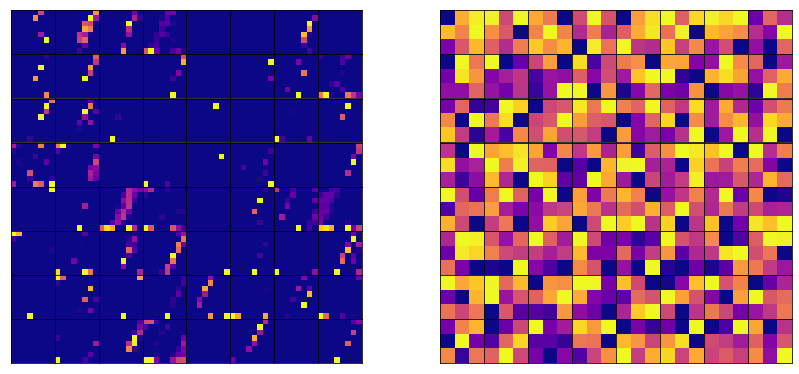

In [24]:
# Feature maps and filters for state
display_cnn_feature_maps_and_filters(model, activation_model, img, total_width=14, cmap='plasma')